In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\spark-2.4.4'

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('MovieLens').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [3]:
from pyspark.sql.functions import *

In [4]:
movies = spark.read.format("csv")\
.options(header = True, inferSchema = True)\
.load("hdfs://localhost:9000/MovieData/input/movie.csv")\
.persist()

movies.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [5]:
movies.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [6]:
ratings = spark.read.format("csv")\
.options(header = True, inferSchema = True)\
.load("hdfs://localhost:9000/MovieData/input/rating.csv")\
.persist()

In [7]:
ratings.show()

+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|      2|   3.5|2005-04-02 23:53:47|
|     1|     29|   3.5|2005-04-02 23:31:16|
|     1|     32|   3.5|2005-04-02 23:33:39|
|     1|     47|   3.5|2005-04-02 23:32:07|
|     1|     50|   3.5|2005-04-02 23:29:40|
|     1|    112|   3.5|2004-09-10 03:09:00|
|     1|    151|   4.0|2004-09-10 03:08:54|
|     1|    223|   4.0|2005-04-02 23:46:13|
|     1|    253|   4.0|2005-04-02 23:35:40|
|     1|    260|   4.0|2005-04-02 23:33:46|
|     1|    293|   4.0|2005-04-02 23:31:43|
|     1|    296|   4.0|2005-04-02 23:32:47|
|     1|    318|   4.0|2005-04-02 23:33:18|
|     1|    337|   3.5|2004-09-10 03:08:29|
|     1|    367|   3.5|2005-04-02 23:53:00|
|     1|    541|   4.0|2005-04-02 23:30:03|
|     1|    589|   3.5|2005-04-02 23:45:57|
|     1|    593|   3.5|2005-04-02 23:31:01|
|     1|    653|   3.0|2004-09-10 03:08:11|
|     1|    919|   3.5|2004-09-1

In [7]:
genre_avg_rating = ratings.alias("t1")\
.join(movies.alias("t2"), col("t1.movieId") == col("t2.movieId"))\
.select(col("rating"), explode(split("genres", r"\|")).alias("genre"))\
.groupBy(col("genre"))\
.agg(count(col("genre")).alias("count"), avg("rating").alias("avg_rating")) \
.orderBy(desc("avg_rating"))

In [25]:
genre_avg_rating.show()

+------------------+-------+------------------+
|             genre|  count|        avg_rating|
+------------------+-------+------------------+
|         Film-Noir| 216689|  3.96538126070082|
|               War|1048618|3.8095307347384844|
|       Documentary| 244619|3.7397176834178865|
|             Crime|3298335|3.6745276025631113|
|             Drama|8857853|3.6742955093068264|
|           Mystery|1557282| 3.663508921312903|
|              IMAX| 492366| 3.655945983272606|
|         Animation|1140476|3.6174939235897994|
|           Western| 423714|3.5704980246109406|
|           Musical| 870915| 3.558090628821412|
|           Romance|3802002| 3.541802581902903|
|          Thriller|5313506|  3.50711121809216|
|           Fantasy|2111403|3.5059453358738244|
|         Adventure|4380351|3.5018926565473865|
|            Action|5614208|  3.44386376493354|
|            Sci-Fi|3150141|3.4367726714455005|
|            Comedy|7502234|3.4260113054324886|
|          Children|1669249|3.4081137685

In [28]:
avg_rating_schema=genre_avg_rating.printSchema()

root
 |-- genre: string (nullable = true)
 |-- count: long (nullable = false)
 |-- avg_rating: double (nullable = true)



In [35]:
genre_avg_rating.coalesce(1).write.csv("hdfs://localhost:9000/MovieData/output/average_rating_genre.csv")

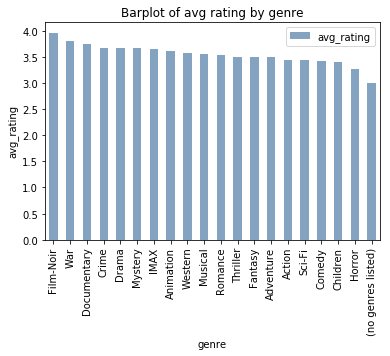

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

df = genre_avg_rating.toPandas()
df.plot("genre", "avg_rating", "bar", title = "Barplot of avg rating by genre", color=(0.2, 0.4, 0.6, 0.6))
plt.xlabel("genre")
plt.ylabel("avg_rating")
plt.show()